In [1]:
# !pip install pykan

In [2]:
import torch
import matplotlib.pyplot as plt
from kan import KAN, create_dataset
from kan.MLP import MLP as kan_MLP
from kan.feynman import get_feynman_dataset

In [3]:
torch.cuda.is_available()

False

In [4]:
class MLP(kan_MLP):

    def __init__(self, width, act='silu', save_act=True, seed=0, device='cpu'):
        super(MLP, self).__init__(width, act, save_act, seed, device)
    
        if act == 'silu':
            self.act_fun = torch.nn.SiLU()
        elif act == 'relu':
            self.act_fun = torch.nn.ReLU()
        elif act == 'tanh':
            self.act_fun = torch.nn.Tanh()

## Experiment Functions

In [5]:
def run_kan_feynman(dataset: str,
                          shape: list[int],
                          samples: int, # samples for both train and test (separated) sets,
                          test_samples: int = None,
                          start_grid: int = 3,
                          k: int = 3,
                          device='cuda' if torch.cuda.is_available() else 'cpu',
                          seed:int=42,
                          grids=[3, 5, 10, 20, 50, 100, 200],
                          steps_per_grid=200,
                          plot_model=False,
                          prune=False,
                          prune_threshold=1e-2,
                          steps_after_prune=200,
                          lamb=0.00,
                          opt="LBFGS",
                          actual_func = None,
                          **kwargs):
    
    assert device in ['cpu', 'cuda']
    try:
        torch.manual_seed(seed)
    except Exception as e:
        print('Warning: could not set torch.manual_seed')
    

    if test_samples is None:
        test_samples = samples
    
    
    if actual_func is not None:
        f = actual_func
        dataset = create_dataset(f, n_var=2, train_num=samples, test_num=test_samples, seed=seed)
    else:
        try:
            symbol, expr, f, ranges = get_feynman_dataset(dataset)
        except ValueError:
            raise ValueError("Invalid dataset name")
        dataset = create_dataset(f, n_var=2, ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        if not shape[-1] == 1:
            print(f"Warning: Output dimension {shape[-1]} is not 1. Forcing condition.")
            shape[-1] = 1
        if not shape[0] == len(ranges):
            print(f"Warning: Input dimension {shape[0]} does not match number of variables in dataset {len(ranges)}. Forcing condition.")
            shape[0] = len(ranges)


    dataset['train_input'] = dataset['train_input'].to(device)
    dataset['train_label'] = dataset['train_label'].to(device)
    dataset['test_input'] = dataset['test_input'].to(device)
    dataset['test_label'] = dataset['test_label'].to(device)

    # assert shape[0] == len(ranges), "Input dimension does not match number of variables in dataset"
    # print(shape)

    # Create a copy of shape before passing to KAN to avoid mutation
    # KAN's __init__ converts [2,5,1] to [[2,0],[5,0],[1,0]] in-place
    model = KAN(width=shape.copy(), grid=start_grid, k=k, seed=seed).to(device)

    per_grid_results = {}

    for i, g in enumerate(grids):
        if i > 0: #skip first iteration
            model = model.refine(g)
        
        print(f"Training grid: {g}")
        results = model.fit(dataset, opt=opt, steps=steps_per_grid, lamb=lamb) #, verbose=verbose)
        per_grid_results[g] = results

    if prune:
        print("Pruning model...")
        model = model.prune(prune_threshold)
        # Disable grid updates after pruning to avoid numerical instability with smaller network
        results = model.fit(dataset, opt=opt, steps=steps_after_prune, lamb=0.0, update_grid=False) #, verbose=verbose)
        per_grid_results['prunning'] = results
        

    if plot_model:
        model.plot()
        plt.show()

    best_test_rmse = min(per_grid_results.values(), key=lambda x: x['test_loss'][-1])['test_loss'][-1]
    
    return model, per_grid_results, best_test_rmse

In [98]:
def sweep_kan_feynman(dataset:str, width: int=5, depths=[2,3,4,5,6], seeds: list[int] = [42, 171, 3], lambs: list[float] = [0.0], **kwargs):

    all_results = {}
    best_test_rmse = float('inf')
    
    # Get dataset info to determine input dimension
    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
        n_inputs = len(ranges)
    except Exception as e:
        raise ValueError(f"Could not load dataset {dataset}")

    for depth in depths:
        all_results[depth] = {}
        for lamb in lambs:
            all_results[depth][lamb] = {}
            for seed in seeds:
                all_results[depth][lamb][seed] = {}
                # Build shape with correct input dimension and output dimension of 1
                # depth includes input and output layers, so we need depth-2 hidden layers
                if depth == 1:
                    shape = [n_inputs, 1]
                else:
                    shape = [n_inputs] + [width for _ in range(depth - 1)] + [1]


                model, per_grid_results, test_rmse = run_kan_feynman(dataset=dataset, shape=shape, lamb=lamb, seed=seed, **kwargs)
                    
                all_results[depth][lamb][seed] = {
                    'model': model,
                    'per_grid_results': per_grid_results,
                    'test_rmse': test_rmse
                }

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse

    return all_results, best_test_rmse

In [7]:
def feynman_human_kan_experiment(dataset: str, shape: list[int], seeds: list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run feynman dataset experiment with human-constructed KAN
    """
    all_results = []
    for seed in seeds:
        results = run_kan_feynman(dataset=dataset,
                                seed=seed,
                                samples=samples,
                                shape=shape,
                                **kwargs)
        all_results.append(results)
    
    best_test_rmse = min([res[2] for res in all_results])

    print('==='*20)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {best_test_rmse:.4e}')

    return best_test_rmse, all_results
    

def feynman_not_pruned_kan_experiment(dataset: str, seeds: list[int], samples=1000, **kwargs):

    results = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                **kwargs)

    # print('==='*20)
    # print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {results[1]:.4e}')
    best_test_rmse = results[1]

    return best_test_rmse, results


def feynman_pruned_kan_experiment(dataset: str, seeds: list[int] = [42, 171, 3], samples: int = 1000, steps_after_prune: int = 100,  lambs=[1e-2, 1e-3], **kwargs):
    """
    Run feynman dataset experiment with pruned KAN
    """
    results, best_test_rmse = sweep_kan_feynman(dataset=dataset,
                                seeds=seeds,
                                samples=samples,
                                prune=True,
                                prune_threshold=0.01,
                                steps_after_prune=steps_after_prune,
                                lambs=lambs,
                                **kwargs)
    

    # get smallest shape with loss < 1e-2
    # get shape of best loss

    smallest_shape = None
    smallest_params = float('inf')
    shape_best_loss = None
    smallest_loss = float('inf')

    for depth, v in results.items():
        for lamb, vv in v.items():
            for seed, res in vv.items():
                test_rmse = res['test_rmse']
                model = res['model']
                shape = [p[0] if isinstance(p, list) else p for p in model.width]
                num_params = sum(p.numel() for p in model.parameters())


                if test_rmse < 1e-2:
                    if smallest_shape is None or sum(shape) < sum(smallest_shape):
                        if num_params > smallest_params and smallest_shape is not None:
                            print(f"Warning: Found smaller shape {shape} with more parameters {num_params} > {smallest_params}. Still taking smallest shape though.")
                        smallest_shape = shape
                        smallest_params = num_params

                if test_rmse < smallest_loss:
                    smallest_loss = test_rmse
                    shape_best_loss = shape


    
    # If no model achieved RMSE < 1e-2, print warning
    if smallest_shape is None:

        print(f"⚠️ WARNING: No model achieved RMSE < 1e-2 for dataset {dataset}")


    return smallest_shape, shape_best_loss, best_test_rmse, results

In [8]:
def feynman_mlp_experiment(dataset: str, seeds: int|list[int] = [42, 171, 3], samples: int = 1000, device='cuda' if torch.cuda.is_available() else 'cpu',
                           activations=['silu', 'relu', 'tanh'], depths = [2,3,4,5,6], steps=1400, lr=1, **kwargs):
    """
    Run feynman dataset experiment with MLP
    """

    assert device in ['cpu', 'cuda']

    all_results = {}
    best_test_rmse = float('inf')

    try:
        symbol, expr, f, ranges = get_feynman_dataset(dataset)
    except ValueError:
        raise ValueError("Invalid dataset name")
    
    for seed in seeds:
        try:
            torch.manual_seed(seed)
        except Exception as e:
            print(f"Warning: could not set seed due to error: {e}")

        dataset = create_dataset(f, n_var=len(ranges), ranges=ranges, train_num=samples, test_num=samples, seed=seed)
        dataset['train_input'] = dataset['train_input'].to(device)
        dataset['train_label'] = dataset['train_label'].to(device)
        dataset['test_input'] = dataset['test_input'].to(device)
        dataset['test_label'] = dataset['test_label'].to(device)

        all_results[seed] = {}
        
        for depth in depths:
            shape = [len(ranges)] + [5 for _ in range(depth-1)] + [1]

            all_results[seed][depth] = {}

            for act in activations:
                model = MLP(width=shape, act=act, seed=seed, device=device)

                results = model.fit(dataset=dataset, steps=steps, opt="LBFGS", lr=lr)
                all_results[seed][depth][act] = results

                test_rmse = min(results['test_loss'])

                if test_rmse < best_test_rmse:
                    best_test_rmse = test_rmse
                
    return all_results, best_test_rmse

In [9]:
def full_feynman_experiment(dataset: str, shape_human: list[int], seeds: list[int] = [42, 171, 3], samples: int = 1000, **kwargs):
    """
    Run full feynman dataset experiment with human-constructed KAN, not pruned KAN, pruned KAN, and MLP
    """

    print('Running Human-constructed KAN Experiment...')
    h_best_test_rmse, h_results = feynman_human_kan_experiment(dataset=dataset, shape=shape_human, seeds=seeds, samples=samples, **kwargs)
    print(f'Best Test RMSE for human-constructed KAN on dataset {dataset}: {h_best_test_rmse:.4e}')

    print('--------------------------------') 
    print('Running Not Pruned KAN Experiment...')
    not_pruned_best_rmse, not_pruned_results = feynman_not_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'Best Test RMSE for not pruned KAN on dataset {dataset}: {not_pruned_best_rmse:.4e}')

    print('--------------------------------') 
    print('Running Pruned KAN Experiment...')
    pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results = feynman_pruned_kan_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
    print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
    print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')

    print('--------------------------------') 
    print('Running MLP Experiment...')
    mlp_results, mlp_best_rmse = feynman_mlp_experiment(dataset=dataset, seeds=seeds, samples=samples, **kwargs)
    print(f'MLP lowest loss: {mlp_best_rmse:.4e}')

    print('--------------------------------') 
    print('==='*40)
    print('==='*40)
    print(f'Final Results for dataset {dataset}:')
    print(f'Pruned KAN Smallest Shape: {pruned_smallest_shape}, ')
    print(f'Pruned KAN lowest loss Shape: {pruned_shape_best_loss}, ')
    print(f'Pruned KAN lowest loss: {pruned_best_rmse:.4e}')
    print(f'Human-constructed KAN loss: {h_best_test_rmse:.4e}')
    print(f'UnPruned KAN lowest loss: {not_pruned_best_rmse:.4e}')
    print(f'MLP lowest loss: {mlp_best_rmse:.4e}')
    print('==='*40)
    print('==='*40)

    return pruned_smallest_shape, pruned_shape_best_loss, pruned_best_rmse, pruned_results

In [12]:
def plot_train_test_loss(results, best_test_rmse) -> None:

    # Plot training and test losses
    # results is a list with one element per seed
    # Each element is (model, per_grid_results, best_test_rmse)
    model, per_grid_results, _ = results[0]  # Get results from the first (and only) seed

    # Concatenate losses from all grids
    train_losses = []
    test_losses = []
    grid_boundaries = [0]  # Track where each grid starts

    for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
        grid_results = per_grid_results[grid_size]
        train_losses.extend(grid_results['train_loss'])
        test_losses.extend(grid_results['test_loss'])
        grid_boundaries.append(len(train_losses))

    # Create the plot
    plt.figure(figsize=(8, 4))
    plt.plot(train_losses, label='Train Loss', linewidth=2)
    plt.plot(test_losses, label='Test Loss', linewidth=2)

    # Add vertical lines to show grid refinements
    for i, boundary in enumerate(grid_boundaries[1:-1], start=1):
        plt.axvline(x=boundary, color='gray', linestyle='--', alpha=0.5, linewidth=1)

    plt.xlabel('Training Steps', fontsize=12)
    plt.ylabel('Loss (RMSE)', fontsize=12)
    plt.title('Training and Test Losses for Dataset I.6.20 (samples=1000, seed=171)', fontsize=14)
    plt.legend(fontsize=11)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"\nFinal Train Loss: {train_losses[-1]:.4e}")
    print(f"Final Test Loss: {test_losses[-1]:.4e}")
    print(f"Best Test RMSE: {best_test_rmse:.4e}")

## Experiments

In [22]:
best_test_rmse, results = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=500, test_samples=2000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.37e-02 | test_loss: 1.93e-02 | reg: 0.00e+00 | :   2%| | 3/200 [00:00<00:22,  8.82it

| train_loss: 9.75e-04 | test_loss: 1.44e-03 | reg: 7.60e+00 | : 100%|█| 200/200 [00:14<00:00, 13.88


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 5.01e-04 | test_loss: 7.30e-04 | reg: 7.62e+00 | : 100%|█| 200/200 [00:17<00:00, 11.76


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.06e-04 | test_loss: 1.72e-04 | reg: 7.51e+00 | : 100%|█| 200/200 [00:19<00:00, 10.08


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 5.68e-05 | test_loss: 2.44e-03 | reg: 7.49e+00 | : 100%|█| 200/200 [00:11<00:00, 17.09


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.63e-05 | test_loss: 2.56e-02 | reg: 7.47e+00 | : 100%|█| 200/200 [00:22<00:00,  9.04


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.91e-05 | test_loss: 5.31e-02 | reg: 7.47e+00 | : 100%|█| 200/200 [00:23<00:00,  8.61


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 8.90e-05 | test_loss: 7.96e-02 | reg: 7.64e+00 | : 100%|█| 200/200 [00:47<00:00,  4.24

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.7175e-04


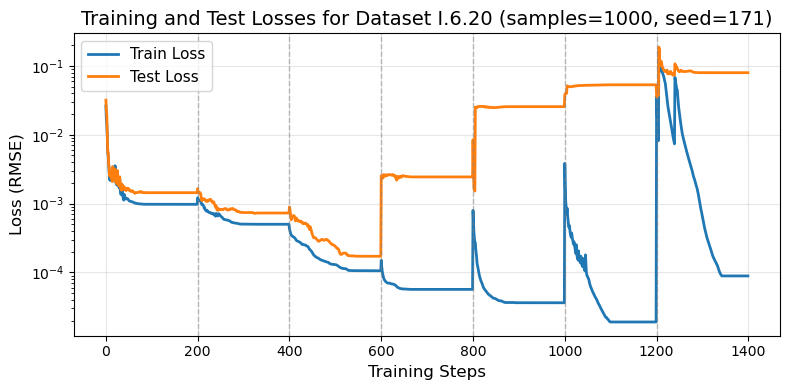


Final Train Loss: 8.8992e-05
Final Test Loss: 7.9627e-02
Best Test RMSE: 1.7175e-04


In [23]:
plot_train_test_loss(results, best_test_rmse)

In [24]:
best_test_rmse_1k, results_1k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=1000, test_samples=2000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.22e-02 | test_loss: 1.31e-02 | reg: 0.00e+00 | :   1%| | 2/200 [00:00<00:29,  6.81it

| train_loss: 1.87e-03 | test_loss: 1.81e-03 | reg: 8.63e+00 | : 100%|█| 200/200 [00:30<00:00,  6.60


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.29e-04 | test_loss: 6.02e-04 | reg: 8.33e+00 | : 100%|█| 200/200 [00:30<00:00,  6.51


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 8.58e-03 | test_loss: 1.05e-02 | reg: 8.24e+00 | : 100%|█| 200/200 [00:38<00:00,  5.18


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 6.30e-03 | test_loss: 8.97e-03 | reg: 8.72e+00 | : 100%|█| 200/200 [01:01<00:00,  3.28


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.15e-03 | test_loss: 9.65e-03 | reg: 8.67e+00 | : 100%|█| 200/200 [00:40<00:00,  4.96


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.12e-03 | test_loss: 1.64e-02 | reg: 8.69e+00 | : 100%|█| 200/200 [01:02<00:00,  3.20


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 8.61e-05 | test_loss: 2.36e-02 | reg: 8.70e+00 | : 100%|█| 200/200 [01:28<00:00,  2.25

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 6.0189e-04


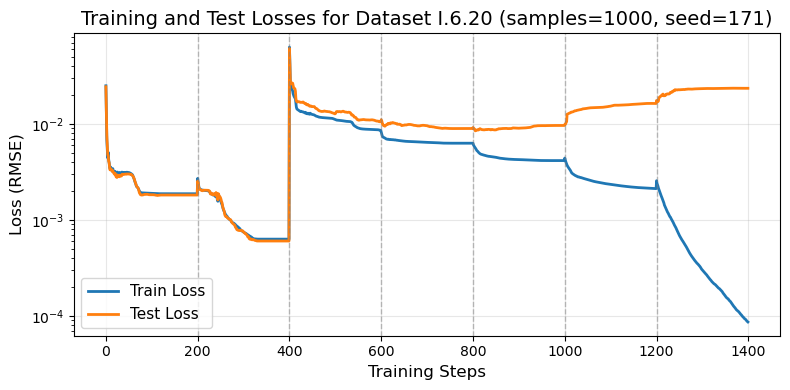


Final Train Loss: 8.6117e-05
Final Test Loss: 2.3560e-02
Best Test RMSE: 6.0189e-04


In [26]:
plot_train_test_loss(results_1k, best_test_rmse_1k)

In [16]:
best_test_rmse_2k5, results_2k5 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=2500)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.51e-02 | test_loss: 2.69e-02 | reg: 0.00e+00 | :   0%| | 1/200 [00:00<00:43,  4.53it

| train_loss: 1.92e-03 | test_loss: 2.00e-03 | reg: 8.65e+00 | : 100%|█| 200/200 [00:44<00:00,  4.51


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.12e-03 | test_loss: 1.14e-03 | reg: 9.07e+00 | : 100%|█| 200/200 [00:42<00:00,  4.71


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.57e-02 | test_loss: 3.23e-02 | reg: 6.54e+00 | : 100%|█| 200/200 [00:45<00:00,  4.36


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.40e-02 | test_loss: 2.99e-02 | reg: 6.62e+00 | : 100%|█| 200/200 [00:44<00:00,  4.50


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 5.77e-03 | test_loss: 1.06e-02 | reg: 5.90e+00 | : 100%|█| 200/200 [00:47<00:00,  4.24


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.00e-03 | test_loss: 1.45e-02 | reg: 5.90e+00 | : 100%|█| 200/200 [01:12<00:00,  2.76


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.76e-03 | test_loss: 1.64e-02 | reg: 5.90e+00 | : 100%|█| 200/200 [01:32<00:00,  2.17

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.1444e-03


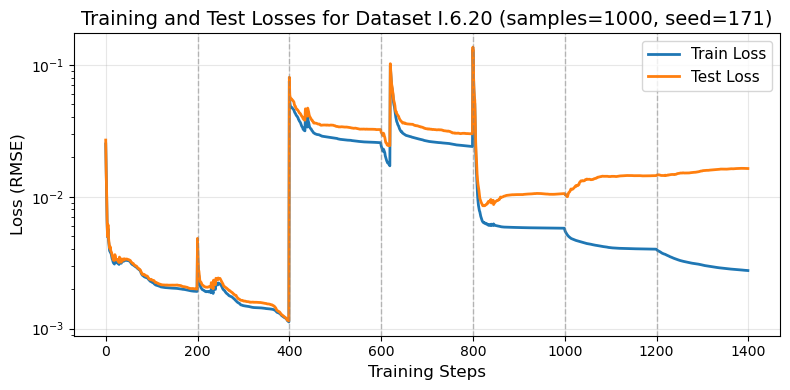


Final Train Loss: 2.7581e-03
Final Test Loss: 1.6354e-02
Best Test RMSE: 1.1444e-03


In [17]:
plot_train_test_loss(results_2k5, best_test_rmse_2k5)

In [18]:
best_test_rmse_5k, results_5k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=5000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.49e-02 | test_loss: 1.50e-02 | reg: 0.00e+00 | :   1%| | 2/200 [00:00<00:51,  3.81it

| train_loss: 2.33e-03 | test_loss: 2.32e-03 | reg: 8.55e+00 | : 100%|█| 200/200 [00:53<00:00,  3.75


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.65e-04 | test_loss: 9.01e-04 | reg: 8.24e+00 | : 100%|█| 200/200 [01:17<00:00,  2.60


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.22e-04 | test_loss: 4.51e-04 | reg: 8.25e+00 | : 100%|█| 200/200 [01:01<00:00,  3.27


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 4.00e-04 | test_loss: 4.40e-04 | reg: 7.81e+00 | : 100%|█| 200/200 [00:50<00:00,  3.94


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.55e-04 | test_loss: 4.08e-04 | reg: 7.81e+00 | : 100%|█| 200/200 [00:35<00:00,  5.60


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.42e-04 | test_loss: 4.11e-04 | reg: 7.81e+00 | : 100%|█| 200/200 [00:55<00:00,  3.62


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.96e-04 | test_loss: 4.59e-04 | reg: 7.81e+00 | : 100%|█| 200/200 [02:58<00:00,  1.12

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 4.0776e-04


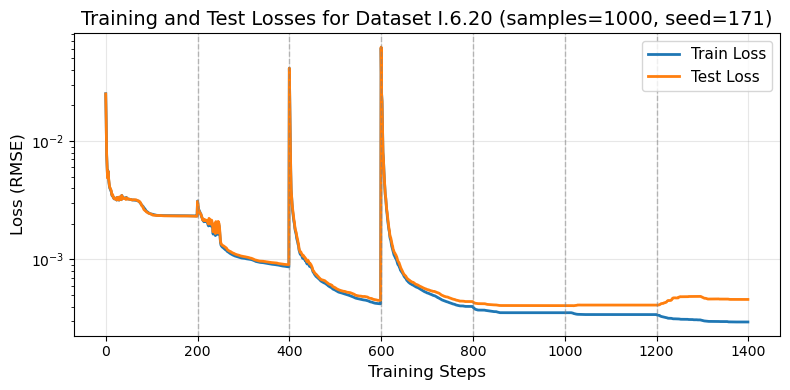


Final Train Loss: 2.9605e-04
Final Test Loss: 4.5894e-04
Best Test RMSE: 4.0776e-04


In [19]:
plot_train_test_loss(results_5k, best_test_rmse_5k)

In [20]:
best_test_rmse_15k, results_15k = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=15000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 5.10e-03 | test_loss: 4.91e-03 | reg: 0.00e+00 | :   3%| | 6/200 [00:02<01:17,  2.49it

| train_loss: 2.18e-03 | test_loss: 2.12e-03 | reg: 8.64e+00 | : 100%|█| 200/200 [01:16<00:00,  2.63


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.90e-04 | test_loss: 8.81e-04 | reg: 8.51e+00 | : 100%|█| 200/200 [01:16<00:00,  2.62


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.99e-04 | test_loss: 4.01e-04 | reg: 8.23e+00 | : 100%|█| 200/200 [02:10<00:00,  1.53


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 5.78e-03 | test_loss: 5.84e-03 | reg: 8.22e+00 | : 100%|█| 200/200 [02:50<00:00,  1.17


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.84e-03 | test_loss: 3.88e-03 | reg: 8.31e+00 | : 100%|█| 200/200 [03:09<00:00,  1.05


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.08e-03 | test_loss: 3.21e-03 | reg: 8.36e+00 | : 100%|█| 200/200 [04:57<00:00,  1.49


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.81e-02 | test_loss: 2.11e-02 | reg: 6.46e+00 | : 100%|█| 200/200 [13:58<00:00,  4.19

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 4.0057e-04


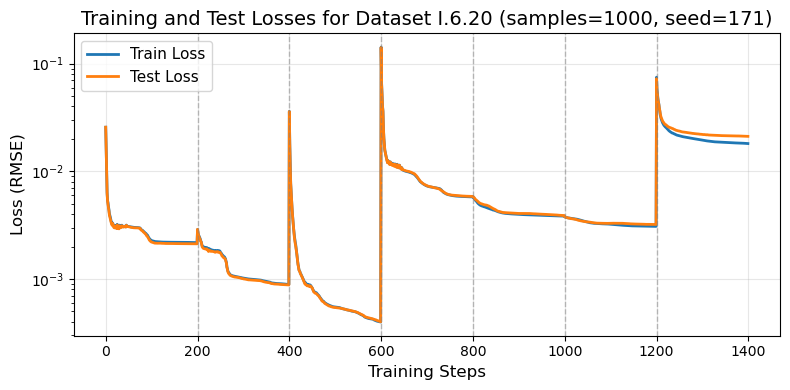


Final Train Loss: 1.8104e-02
Final Test Loss: 2.1117e-02
Best Test RMSE: 4.0057e-04


In [21]:
plot_train_test_loss(results_15k, best_test_rmse_15k)

In [153]:
def plot_train_test_loss_small_multiples(results_dict: dict, dataset_name: str = 'I.6.20', max_cols=4, title=None) -> None:
    """
    Plot training and test losses in small multiples (subplots) for comparison.
    
    Args:
        results_dict: Dictionary with keys as labels (e.g., '500 samples') and values as 
                     (best_test_rmse, results) tuples from feynman_human_kan_experiment
        dataset_name: Name of the dataset for the title
    """
    n_plots = len(results_dict)
    n_cols = min(max_cols, n_plots)  # Max 3 columns
    n_rows = (n_plots + n_cols - 1) // n_cols
    
    # First pass: collect all losses to determine global y-axis scale
    all_train_losses = []
    all_test_losses = []
    
    for label, (best_test_rmse, results) in results_dict.items():
        model, per_grid_results, _ = results[0]
        
        train_losses = []
        test_losses = []
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
        
        all_train_losses.extend(train_losses)
        all_test_losses.extend(test_losses)
    
    # Determine global y-axis limits
    y_min = min(min(all_train_losses), min(all_test_losses))
    y_max = max(max(all_train_losses), max(all_test_losses))
    
    # Create subplots
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(6*n_cols, 5*n_rows))
    if n_plots == 1:
        axes = [axes]
    else:
        axes = axes.flatten() if n_plots > 1 else [axes]
    
    # Define grid sizes and positions
    grid_sizes = [3, 5, 10, 20, 50, 100, 200]
    grid_positions = [i * 200 for i in range(len(grid_sizes))]
    
    # Plot each result
    for idx, (label, (best_test_rmse, results)) in enumerate(results_dict.items()):
        ax = axes[idx]
        model, per_grid_results, _ = results[0]
        
        # Concatenate losses from all grids
        train_losses = []
        test_losses = []
        grid_boundaries = [0]
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
            grid_boundaries.append(len(train_losses))
        
        # Plot
        ax.plot(train_losses, label='Train Loss', linewidth=2)
        ax.plot(test_losses, label='Test Loss', linewidth=2)
        
        # Add inclined grid labels above x-axis
        for pos, grid_label in zip(grid_positions, grid_sizes):
            ax.text(pos, ax.get_ylim()[0], f'grid={grid_label}', 
                   rotation=45, ha='left', va='bottom', fontsize=9,
                   transform=ax.get_xaxis_transform())
        
        ax.set_xlabel('Training Steps', fontsize=11, labelpad=10)
        ax.set_ylabel('Loss (RMSE)', fontsize=11, labelpad=20)
        ax.set_title(f'{label}\nBest Test RMSE: {best_test_rmse:.4e}', fontsize=12)
        ax.legend(fontsize=10)
        ax.set_yscale('log')
        ax.set_ylim(y_min, y_max)  # Set same y-axis scale for all plots
        ax.grid(False)  # Remove grid lines
    
    # Hide unused subplots
    for idx in range(n_plots, len(axes)):
        axes[idx].axis('off')
    
    if title is not None:
        fig.suptitle(title, fontsize=16, y=1.02)
    else:   
        fig.suptitle(f'Training Comparison - Dataset {dataset_name}', fontsize=16, y=1.00)
    plt.tight_layout()
    plt.show()


def plot_train_test_loss_combined(results_dict: dict, dataset_name: str = 'I.6.20', 
                                   plot_mode: str = 'both') -> None:
    """
    Plot all training and test losses on a single plot with different colors.
    
    Args:
        results_dict: Dictionary with keys as labels (e.g., '500 samples') and values as 
                     (best_test_rmse, results) tuples from feynman_human_kan_experiment
        dataset_name: Name of the dataset for the title
        plot_mode: 'train', 'test', or 'both' - determines which losses to plot
    """
    assert plot_mode in ['train', 'test', 'both'], "plot_mode must be 'train', 'test', or 'both'"
    
    # Define color palette
    colors = plt.cm.tab10(range(len(results_dict)))
    
    plt.figure(figsize=(14, 7))
    
    # Plot each result
    for idx, (label, (best_test_rmse, results)) in enumerate(results_dict.items()):
        model, per_grid_results, _ = results[0]
        color = colors[idx]
        
        # Concatenate losses from all grids
        train_losses = []
        test_losses = []
        grid_boundaries = [0]
        
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
            grid_boundaries.append(len(train_losses))
        
        # Plot based on mode
        if plot_mode in ['train', 'both']:
            plt.plot(train_losses, label=f'{label} - Train', linewidth=2.5, 
                    color=color, linestyle='-', alpha=0.8)
        
        if plot_mode in ['test', 'both']:
            plt.plot(test_losses, label=f'{label} - Test', linewidth=2.5, 
                    color=color, linestyle='--', alpha=0.8)
    
    # Add vertical lines for grid refinements (using the last result's boundaries)
    # Assuming all results have the same grid structure
    if results_dict:
        first_result = list(results_dict.values())[0]
        model, per_grid_results, _ = first_result[1][0]
        
        train_losses = []
        grid_boundaries = [0]
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            grid_boundaries.append(len(train_losses))
        
        for i, boundary in enumerate(grid_boundaries[1:-1], start=1):
            plt.axvline(x=boundary, color='gray', linestyle=':', alpha=0.3, linewidth=1.5)
    
    plt.xlabel('Training Steps', fontsize=13)
    plt.ylabel('Loss (RMSE)', fontsize=13)
    
    mode_text = {'train': 'Training', 'test': 'Test', 'both': 'Training and Test'}
    plt.title(f'{mode_text[plot_mode]} Losses Comparison - Dataset {dataset_name}', fontsize=15)
    
    plt.legend(fontsize=10, loc='best', ncol=1 if len(results_dict) <= 4 else 2)
    plt.yscale('log')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\n" + "="*60)
    print(f"Summary Statistics for {dataset_name}")
    print("="*60)
    for label, (best_test_rmse, results) in results_dict.items():
        model, per_grid_results, _ = results[0]
        
        train_losses = []
        test_losses = []
        for grid_size in sorted([k for k in per_grid_results.keys() if isinstance(k, int)]):
            grid_results = per_grid_results[grid_size]
            train_losses.extend(grid_results['train_loss'])
            test_losses.extend(grid_results['test_loss'])
        
        print(f"\n{label}:")
        print(f"  Final Train Loss: {train_losses[-1]:.4e}")
        print(f"  Final Test Loss:  {test_losses[-1]:.4e}")
        print(f"  Best Test RMSE:   {best_test_rmse:.4e}")
    print("="*60)

In [74]:
# results_dict_ = {
#     '500 samples': (best_test_rmse, results[0][1]),
#     '1k samples': (best_test_rmse_1k, results_1k[0][1]),
#     '2.5k samples': (best_test_rmse_2k5, results_2k5[0][1]),
#     '5k samples': (best_test_rmse_5k, results_5k[0][1]),
#     '15k samples': (best_test_rmse_15k, results_15k[0][1])
# }

# import pickle

# with open('diff_training_samples_results.pkl', 'wb') as f:
#     pickle.dump(results_dict_, f)

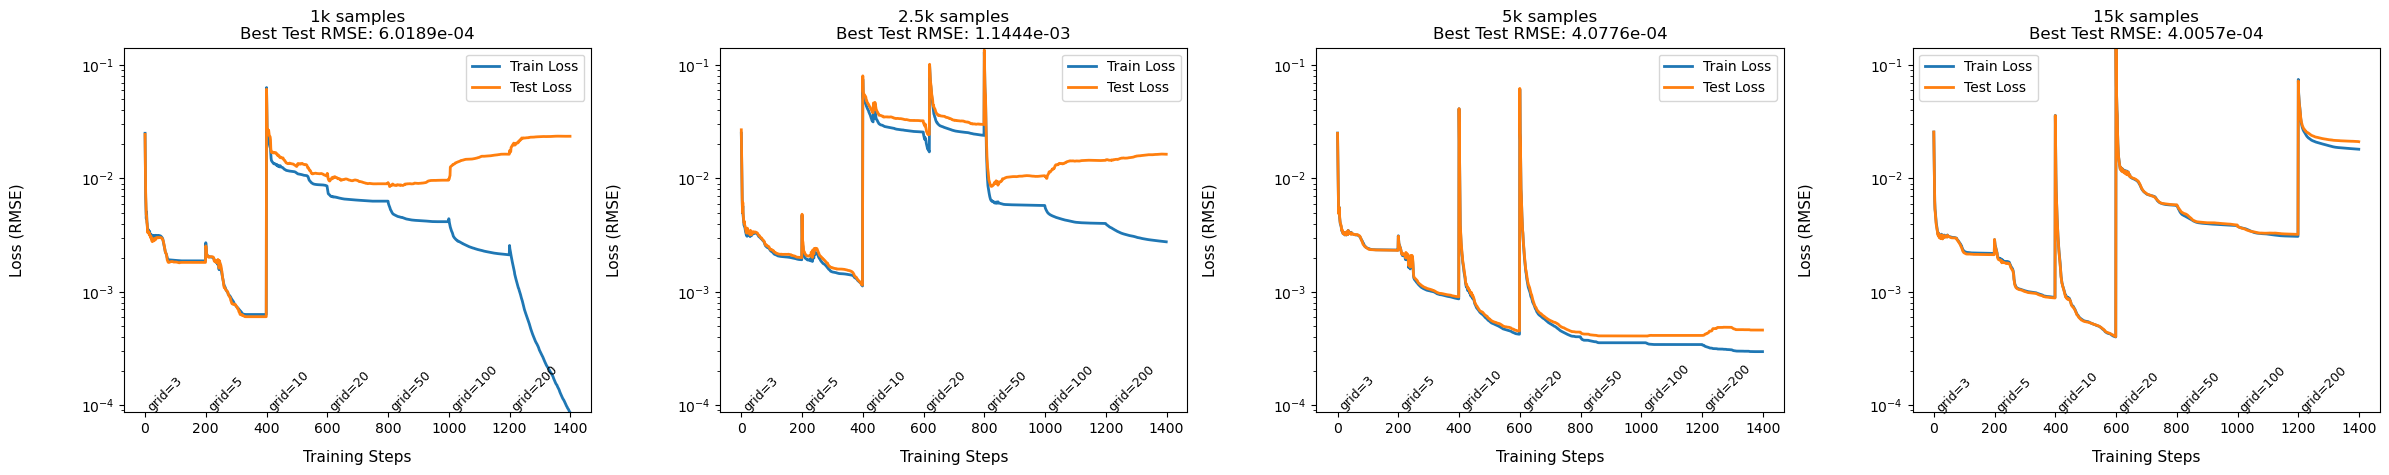

In [75]:
# Prepare your results dictionary
results_dict = {
    # '500 samples': (best_test_rmse, results),
    '1k samples': (best_test_rmse_1k, results_1k),
    '2.5k samples': (best_test_rmse_2k5, results_2k5),
    '5k samples': (best_test_rmse_5k, results_5k),
    '15k samples': (best_test_rmse_15k, results_15k)
}

# Small multiples plot with same y-axis scale
plot_train_test_loss_small_multiples(results_dict, dataset_name='I.6.20', title='')

# Combined plot - both train and test
# plot_train_test_loss_combined(results_dict, dataset_name='I.6.20', plot_mode='both')

# # Combined plot - only test losses
# plot_train_test_loss_combined(results_dict, dataset_name='I.6.20', plot_mode='test')

# # Combined plot - only train losses
# plot_train_test_loss_combined(results_dict, dataset_name='I.6.20', plot_mode='train')

## Training with different seeds

In [76]:
best_test_rmse_1, results_1 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[1], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 6.52e-04 | test_loss: 6.72e-04 | reg: 6.77e+00 | : 100%|█| 200/200 [00:24<00:00,  8.04


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.33e-04 | test_loss: 3.54e-04 | reg: 6.88e+00 | : 100%|█| 200/200 [00:23<00:00,  8.55


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.76e-05 | test_loss: 6.75e-05 | reg: 6.65e+00 | : 100%|█| 200/200 [00:21<00:00,  9.43


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.75e-05 | test_loss: 3.02e-05 | reg: 6.65e+00 | : 100%|█| 200/200 [00:15<00:00, 12.75


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 2.22e-05 | test_loss: 3.51e-05 | reg: 6.65e+00 | : 100%|█| 200/200 [00:13<00:00, 15.21


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.33e-05 | test_loss: 4.88e-05 | reg: 6.65e+00 | : 100%|█| 200/200 [00:16<00:00, 12.31


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.99e-06 | test_loss: 1.61e-04 | reg: 6.65e+00 | : 100%|█| 200/200 [00:19<00:00, 10.25


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 3.0229e-05


In [77]:
best_test_rmse_2, results_2 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[2], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.10e-03 | test_loss: 1.47e-03 | reg: 7.64e+00 | : 100%|█| 200/200 [00:30<00:00,  6.56


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 6.46e-04 | test_loss: 1.02e-03 | reg: 8.83e+00 | : 100%|█| 200/200 [00:29<00:00,  6.78


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.76e-04 | test_loss: 4.95e-04 | reg: 9.04e+00 | : 100%|█| 200/200 [00:27<00:00,  7.28


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.08e-04 | test_loss: 2.57e-04 | reg: 9.20e+00 | : 100%|█| 200/200 [00:33<00:00,  5.97


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 8.26e-05 | test_loss: 2.32e-04 | reg: 9.20e+00 | : 100%|█| 200/200 [00:16<00:00, 12.28


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 6.49e-05 | test_loss: 5.94e-04 | reg: 9.19e+00 | : 100%|█| 200/200 [00:17<00:00, 11.30


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.58e-05 | test_loss: 6.47e-03 | reg: 9.16e+00 | : 100%|█| 200/200 [00:28<00:00,  6.96

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.3240e-04


In [78]:
best_test_rmse_3, results_3 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[3], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.63e-03 | test_loss: 1.77e-03 | reg: 8.85e+00 | : 100%|█| 200/200 [00:28<00:00,  6.98


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.12e-03 | test_loss: 1.17e-03 | reg: 8.83e+00 | : 100%|█| 200/200 [00:29<00:00,  6.78


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.13e-04 | test_loss: 3.88e-04 | reg: 8.90e+00 | : 100%|█| 200/200 [00:30<00:00,  6.58


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.38e-04 | test_loss: 3.32e-04 | reg: 8.90e+00 | : 100%|█| 200/200 [00:23<00:00,  8.48


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.48e-04 | test_loss: 2.65e-04 | reg: 8.90e+00 | : 100%|█| 200/200 [00:24<00:00,  8.06


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.12e-04 | test_loss: 5.37e-04 | reg: 8.89e+00 | : 100%|█| 200/200 [00:21<00:00,  9.35


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.44e-05 | test_loss: 5.86e-03 | reg: 8.89e+00 | : 100%|█| 200/200 [00:45<00:00,  4.43

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.6493e-04


In [79]:
best_test_rmse_4, results_4 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[4], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 7.53e-04 | test_loss: 8.07e-04 | reg: 7.42e+00 | : 100%|█| 200/200 [00:27<00:00,  7.29


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 5.31e-04 | test_loss: 6.22e-04 | reg: 8.18e+00 | : 100%|█| 200/200 [00:23<00:00,  8.57


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.27e-04 | test_loss: 1.76e-04 | reg: 8.23e+00 | : 100%|█| 200/200 [00:20<00:00,  9.98


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 5.50e-05 | test_loss: 7.64e-05 | reg: 8.07e+00 | : 100%|█| 200/200 [00:29<00:00,  6.73


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.53e-05 | test_loss: 9.25e-05 | reg: 8.07e+00 | : 100%|█| 200/200 [00:21<00:00,  9.29


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 3.17e-05 | test_loss: 3.40e-04 | reg: 8.07e+00 | : 100%|█| 200/200 [00:21<00:00,  9.45


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.62e-06 | test_loss: 2.59e-03 | reg: 8.07e+00 | : 100%|█| 200/200 [00:30<00:00,  6.63

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 7.6405e-05


In [ ]:
diff_seeds_results_dict_ = {
    # '500 samples': (best_test_rmse, results),
    'Seed=1': (best_test_rmse_1, results_1[0][1]),
    'Seed=2': (best_test_rmse_2, results_2[0][1]),
    'Seed=3': (best_test_rmse_3, results_3[0][1]),
    'Seed=4': (best_test_rmse_4, results_4[0][1])
}

import pickle
with open('diff_seeds_results.pkl', 'wb') as f:
    pickle.dump(diff_seeds_results_dict_, f)

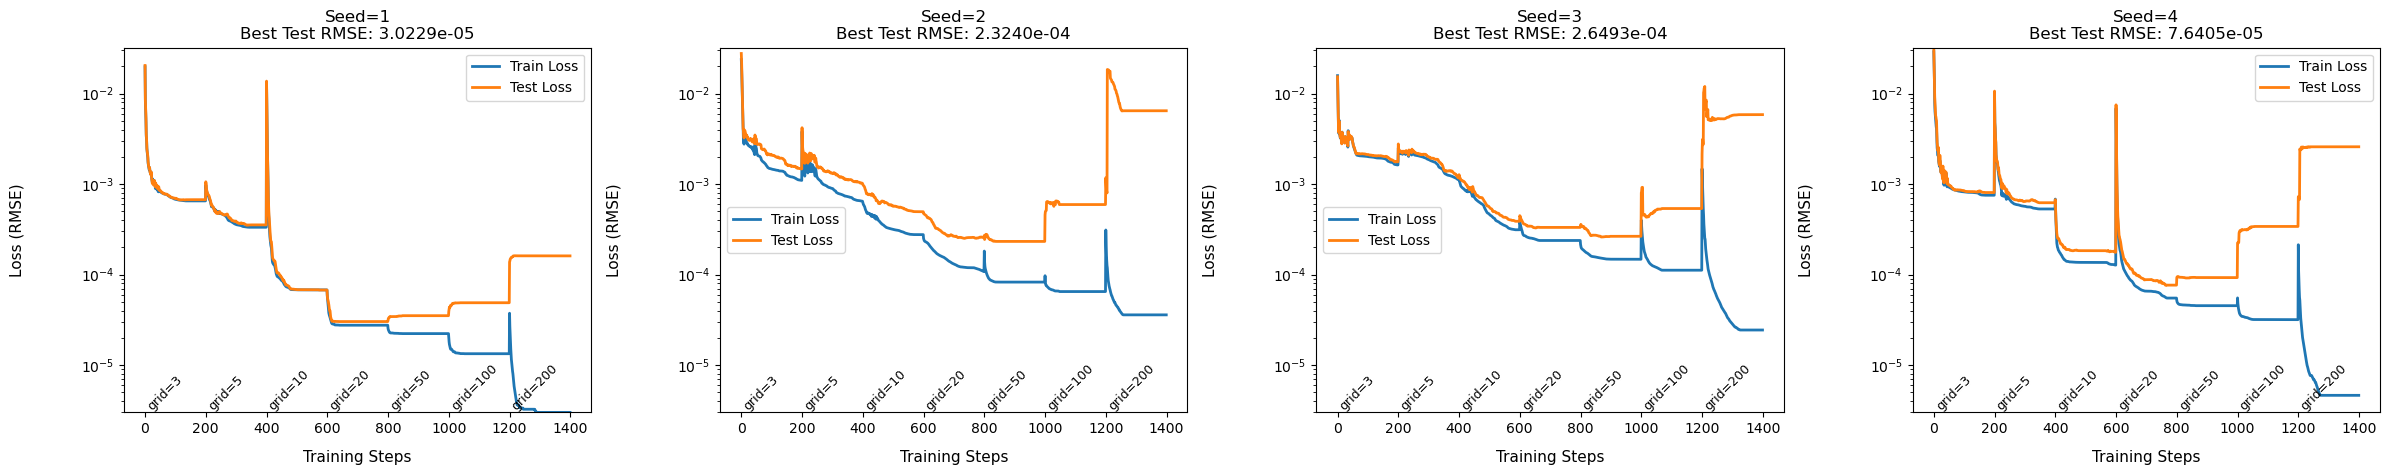

In [84]:
diff_seeds_results_dict = {
    # '500 samples': (best_test_rmse, results),
    'Seed=1': (best_test_rmse_1, results_1),
    'Seed=2': (best_test_rmse_2, results_2),
    'Seed=3': (best_test_rmse_3, results_3),
    'Seed=4': (best_test_rmse_4, results_4)
}

plot_train_test_loss_small_multiples(diff_seeds_results_dict, dataset_name='I.6.20', title='')

In [85]:
best_test_rmse_1, results_1 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[1], samples=1000)
best_test_rmse_2, results_2 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[2], samples=1000)
best_test_rmse_3, results_3 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[3], samples=1000)
best_test_rmse_4, results_4 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[4], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.43e-04 | test_loss: 2.33e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:44<00:00,  4.50


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.23e-04 | test_loss: 1.17e-04 | reg: 1.12e+01 | : 100%|█| 200/200 [00:25<00:00,  7.84


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.60e-05 | test_loss: 2.76e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:33<00:00,  5.99


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 6.83e-06 | test_loss: 9.43e-06 | reg: 1.12e+01 | : 100%|█| 200/200 [00:48<00:00,  4.15


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 4.48e-06 | test_loss: 1.06e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:32<00:00,  6.19


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 2.52e-06 | test_loss: 1.74e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:44<00:00,  4.49


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 6.98e-07 | test_loss: 4.21e-05 | reg: 1.12e+01 | : 100%|█| 200/200 [00:45<00:00,  4.36


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 9.4311e-06
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.76e-04 | test_loss: 2.11e-04 | reg: 1.00e+01 | : 100%|█| 200/200 [00:30<00:00,  6.60


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.86e-05 | test_loss: 1.23e-04 | reg: 9.96e+00 | : 100%|█| 200/200 [00:21<00:00,  9.38


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.07e-05 | test_loss: 2.95e-05 | reg: 9.96e+00 | : 100%|█| 200/200 [00:28<00:00,  6.96


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 7.91e-06 | test_loss: 7.98e-05 | reg: 9.96e+00 | : 100%|█| 200/200 [00:32<00:00,  6.23


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 5.88e-06 | test_loss: 4.89e-04 | reg: 9.94e+00 | : 100%|█| 200/200 [00:32<00:00,  6.23


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 6.66e-06 | test_loss: 6.04e-03 | reg: 9.82e+00 | : 100%|█| 200/200 [00:41<00:00,  4.85


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 4.02e-06 | test_loss: 3.82e-02 | reg: 9.81e+00 | : 100%|█| 200/200 [00:37<00:00,  5.29


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.9527e-05
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.56e-04 | test_loss: 3.81e-04 | reg: 1.22e+01 | : 100%|█| 200/200 [00:42<00:00,  4.68


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.42e-04 | test_loss: 1.86e-04 | reg: 1.21e+01 | : 100%|█| 200/200 [00:22<00:00,  8.70


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 4.14e-05 | test_loss: 8.73e-05 | reg: 1.21e+01 | : 100%|█| 200/200 [00:27<00:00,  7.32


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.40e-05 | test_loss: 8.50e-05 | reg: 1.21e+01 | : 100%|█| 200/200 [00:25<00:00,  7.90


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 7.08e-06 | test_loss: 2.10e-03 | reg: 1.21e+01 | : 100%|█| 200/200 [00:27<00:00,  7.17


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.97e-06 | test_loss: 1.01e-02 | reg: 1.21e+01 | : 100%|█| 200/200 [00:49<00:00,  4.05


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.08e-05 | test_loss: 3.63e-02 | reg: 1.16e+01 | : 100%|█| 200/200 [01:00<00:00,  3.31


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 8.4958e-05
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 4.09e-04 | test_loss: 4.45e-04 | reg: 1.17e+01 | : 100%|█| 200/200 [00:44<00:00,  4.50


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.60e-04 | test_loss: 2.58e-04 | reg: 1.10e+01 | : 100%|█| 200/200 [00:39<00:00,  5.12


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 6.00e-05 | test_loss: 8.92e-05 | reg: 1.10e+01 | : 100%|█| 200/200 [00:44<00:00,  4.46


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.24e-05 | test_loss: 1.49e-04 | reg: 1.10e+01 | : 100%|█| 200/200 [00:28<00:00,  6.95


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.05e-05 | test_loss: 1.84e-03 | reg: 1.10e+01 | : 100%|█| 200/200 [00:34<00:00,  5.78


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.38e-05 | test_loss: 7.43e-03 | reg: 1.10e+01 | : 100%|█| 200/200 [00:42<00:00,  4.74


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 8.13e-07 | test_loss: 1.36e-02 | reg: 1.10e+01 | : 100%|█| 200/200 [00:33<00:00,  5.95

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 8.9227e-05


In [86]:
diff_seeds_results_dict_ = {
    # '500 samples': (best_test_rmse, results),
    'Seed=1': (best_test_rmse_1, results_1[0][1]),
    'Seed=2': (best_test_rmse_2, results_2[0][1]),
    'Seed=3': (best_test_rmse_3, results_3[0][1]),
    'Seed=4': (best_test_rmse_4, results_4[0][1])
}

import pickle
with open('diff_seeds_results_big_size.pkl', 'wb') as f:
    pickle.dump(diff_seeds_results_dict_, f)

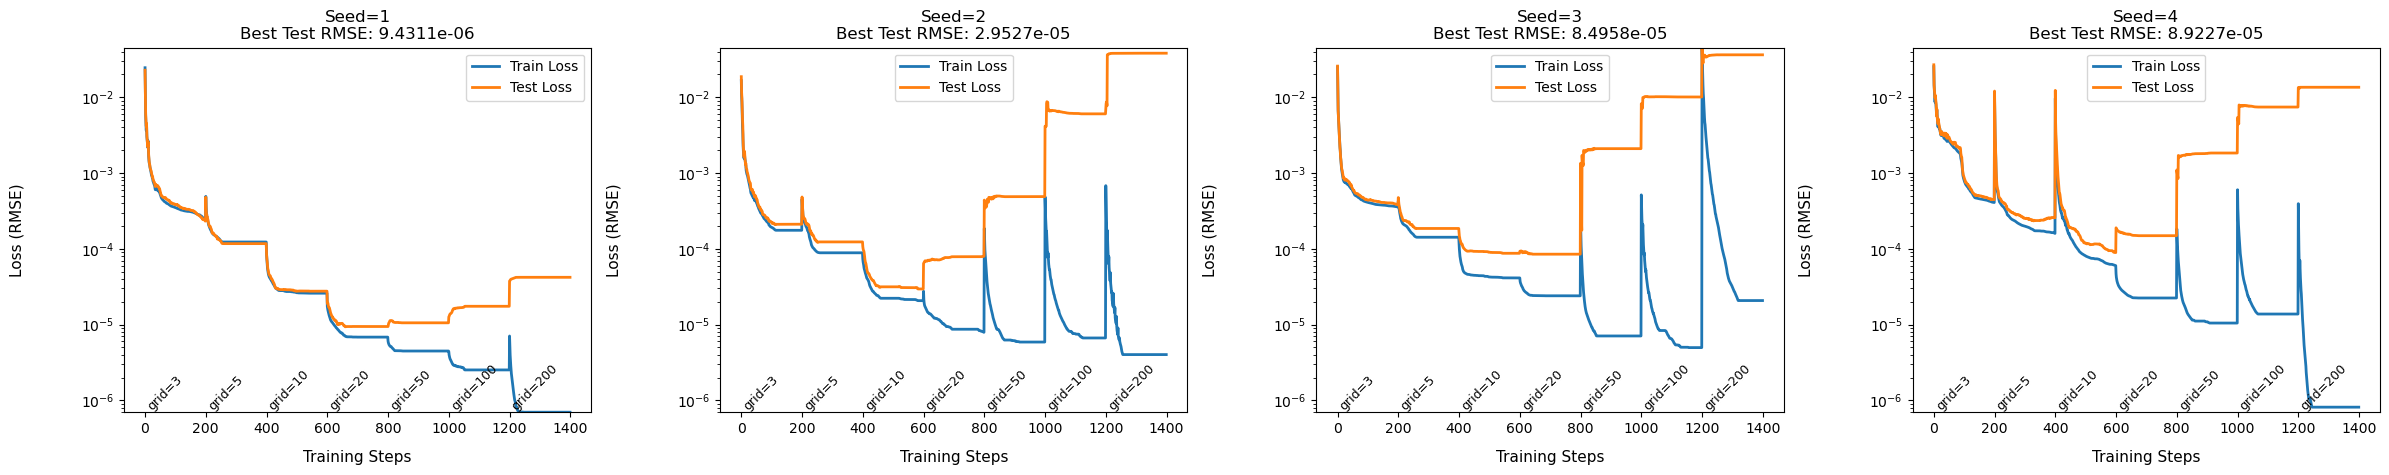

In [87]:
diff_seeds_results_dict = {
    # '500 samples': (best_test_rmse, results),
    'Seed=1': (best_test_rmse_1, results_1),
    'Seed=2': (best_test_rmse_2, results_2),
    'Seed=3': (best_test_rmse_3, results_3),
    'Seed=4': (best_test_rmse_4, results_4)
}

plot_train_test_loss_small_multiples(diff_seeds_results_dict, dataset_name='I.6.20', title='')

In [94]:
best_test_rmse_1, results_1 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[42], samples=1000)
best_test_rmse_2, results_2 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[171], samples=1000)
best_test_rmse_3, results_3 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[55], samples=1000)
best_test_rmse_4, results_4 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 1], seeds=[44], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.90e-02 | test_loss: 2.91e-02 | reg: 0.00e+00 | :   0%| | 1/200 [00:00<00:32,  6.13it

| train_loss: 2.07e-03 | test_loss: 1.99e-03 | reg: 8.63e+00 | : 100%|█| 200/200 [00:37<00:00,  5.33


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.14e-03 | test_loss: 1.11e-03 | reg: 9.04e+00 | : 100%|█| 200/200 [00:29<00:00,  6.67


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 2.80e-04 | test_loss: 3.58e-04 | reg: 8.76e+00 | : 100%|█| 200/200 [00:27<00:00,  7.30


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.38e-04 | test_loss: 2.25e-04 | reg: 8.75e+00 | : 100%|█| 200/200 [00:37<00:00,  5.30


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.11e-04 | test_loss: 2.38e-04 | reg: 8.74e+00 | : 100%|█| 200/200 [00:21<00:00,  9.26


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 7.37e-05 | test_loss: 2.94e-04 | reg: 8.74e+00 | : 100%|█| 200/200 [00:30<00:00,  6.56


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.61e-03 | test_loss: 4.15e-02 | reg: 7.83e+00 | : 100%|█| 200/200 [00:57<00:00,  3.48


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.2504e-04
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.87e-03 | test_loss: 1.82e-03 | reg: 8.64e+00 | : 100%|█| 200/200 [00:21<00:00,  9.24


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 5.95e-04 | test_loss: 5.80e-04 | reg: 8.39e+00 | : 100%|█| 200/200 [00:30<00:00,  6.60


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.39e-02 | test_loss: 1.96e-02 | reg: 7.10e+00 | : 100%|█| 200/200 [00:31<00:00,  6.34


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 8.80e-03 | test_loss: 1.54e-02 | reg: 7.18e+00 | : 100%|█| 200/200 [00:41<00:00,  4.85


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 5.10e-03 | test_loss: 1.36e-02 | reg: 7.26e+00 | : 100%|█| 200/200 [00:48<00:00,  4.14


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 5.33e-03 | test_loss: 2.61e-02 | reg: 7.45e+00 | : 100%|█| 200/200 [01:02<00:00,  3.22


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.74e-03 | test_loss: 3.80e-02 | reg: 7.49e+00 | : 100%|█| 200/200 [01:12<00:00,  2.74


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 5.7989e-04
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.35e-03 | test_loss: 2.31e-03 | reg: 8.44e+00 | : 100%|█| 200/200 [00:30<00:00,  6.61


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.26e-04 | test_loss: 8.56e-04 | reg: 8.56e+00 | : 100%|█| 200/200 [00:25<00:00,  7.85


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 8.23e-04 | test_loss: 8.42e-04 | reg: 7.47e+00 | : 100%|█| 200/200 [00:33<00:00,  5.93


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 2.48e-04 | test_loss: 4.41e-04 | reg: 7.76e+00 | : 100%|█| 200/200 [00:43<00:00,  4.58


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.86e-04 | test_loss: 4.24e-04 | reg: 7.77e+00 | : 100%|█| 200/200 [00:19<00:00, 10.37


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.25e-04 | test_loss: 4.79e-04 | reg: 7.77e+00 | : 100%|█| 200/200 [00:32<00:00,  6.24


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.91e-05 | test_loss: 7.33e-04 | reg: 7.77e+00 | : 100%|█| 200/200 [01:14<00:00,  2.69


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 4.2437e-04
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.90e-03 | test_loss: 2.10e-03 | reg: 8.70e+00 | : 100%|█| 200/200 [00:29<00:00,  6.82


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 8.30e-04 | test_loss: 1.02e-03 | reg: 8.26e+00 | : 100%|█| 200/200 [00:45<00:00,  4.43


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.87e-04 | test_loss: 5.17e-04 | reg: 7.99e+00 | : 100%|█| 200/200 [00:47<00:00,  4.19


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.90e-02 | test_loss: 2.64e-02 | reg: 5.85e+00 | : 100%|█| 200/200 [00:59<00:00,  3.37


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.04e-02 | test_loss: 2.30e-02 | reg: 5.85e+00 | : 100%|█| 200/200 [00:49<00:00,  4.01


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 6.32e-03 | test_loss: 2.77e-02 | reg: 5.86e+00 | : 100%|█| 200/200 [00:44<00:00,  4.51


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 3.94e-03 | test_loss: 5.69e-02 | reg: 5.28e+00 | : 100%|█| 200/200 [01:04<00:00,  3.09

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 5.1673e-04


In [95]:
diff_seeds_results_dict_ = {
    # '500 samples': (best_test_rmse, results),
    'Seed=42': (best_test_rmse_1, results_1[0][1]),
    'Seed=171': (best_test_rmse_2, results_2[0][1]),
    'Seed=55': (best_test_rmse_3, results_3[0][1]),
    'Seed=44': (best_test_rmse_4, results_4[0][1])
}

import pickle
with open('diff_seeds_results_seeds2.pkl', 'wb') as f:
    pickle.dump(diff_seeds_results_dict_, f)

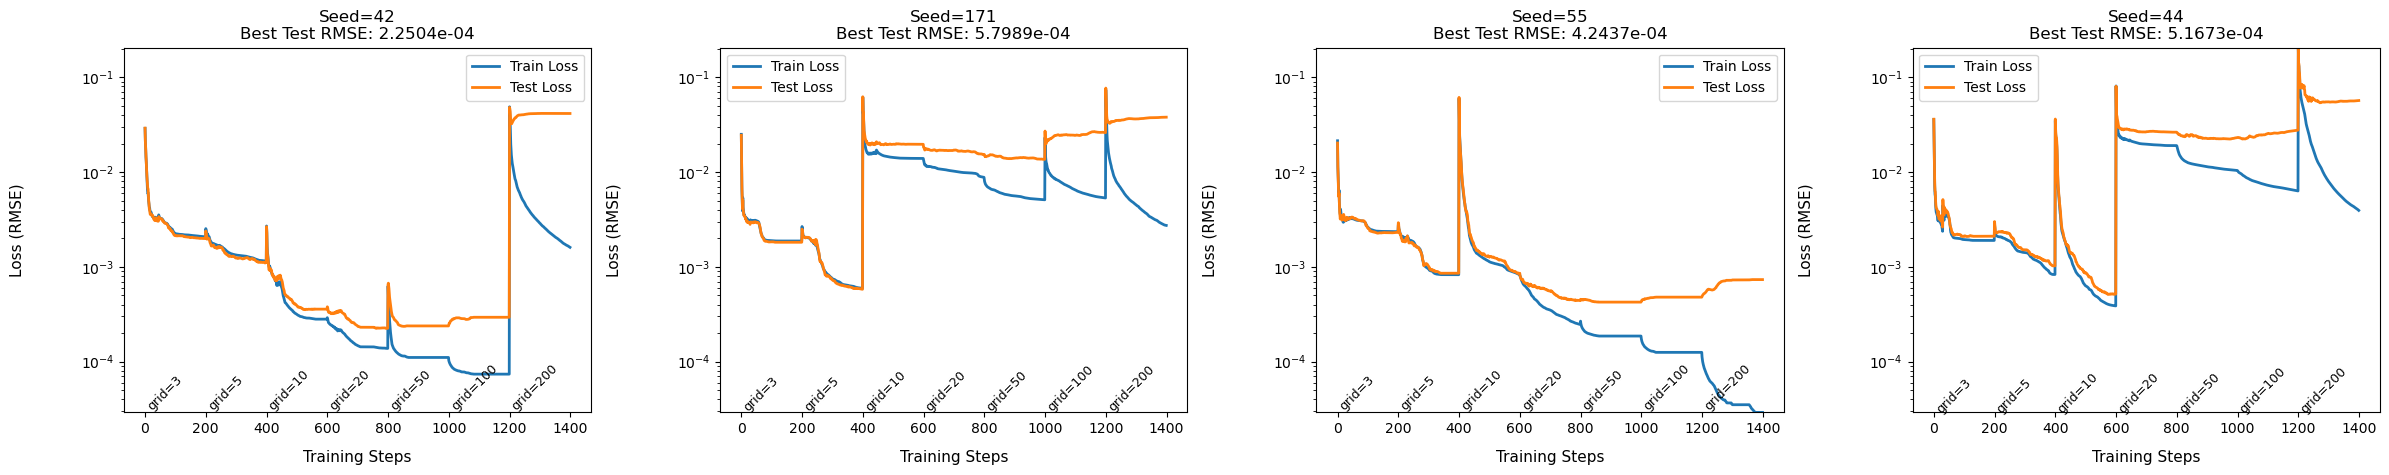

In [96]:
diff_seeds_results_dict = {
    # '500 samples': (best_test_rmse, results),
    'Seed=42': (best_test_rmse_1, results_1),
    'Seed=171': (best_test_rmse_2, results_2),
    'Seed=55': (best_test_rmse_3, results_3),
    'Seed=44': (best_test_rmse_4, results_4)
}

plot_train_test_loss_small_multiples(diff_seeds_results_dict, dataset_name='I.6.20', title='')

In [88]:
best_test_rmse_1, results_1 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[42], samples=1000)
best_test_rmse_2, results_2 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[171], samples=1000)
best_test_rmse_3, results_3 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[55], samples=1000)
best_test_rmse_4, results_4 = feynman_human_kan_experiment(dataset='I.6.20', shape=[2, 2, 2, 1], seeds=[44], samples=1000)

checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 2.87e-04 | test_loss: 3.16e-04 | reg: 9.62e+00 | : 100%|█| 200/200 [00:43<00:00,  4.57


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.56e-04 | test_loss: 1.75e-04 | reg: 9.55e+00 | : 100%|█| 200/200 [00:23<00:00,  8.44


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.29e-05 | test_loss: 3.51e-05 | reg: 9.52e+00 | : 100%|█| 200/200 [00:39<00:00,  5.10


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.51e-05 | test_loss: 2.07e-05 | reg: 9.51e+00 | : 100%|█| 200/200 [00:28<00:00,  6.94


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.43e-05 | test_loss: 5.35e-05 | reg: 9.44e+00 | : 100%|█| 200/200 [01:05<00:00,  3.06


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.61e-03 | test_loss: 8.22e-02 | reg: 9.04e+00 | : 100%|█| 200/200 [01:14<00:00,  2.70


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.74e-01 | test_loss: 2.25e-01 | reg: 8.75e+00 | : 100%|█| 200/200 [01:33<00:00,  2.14


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.0745e-05
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 7.42e-04 | test_loss: 7.79e-04 | reg: 1.05e+01 | : 100%|█| 200/200 [00:44<00:00,  4.54


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 2.49e-04 | test_loss: 3.11e-04 | reg: 1.04e+01 | : 100%|█| 200/200 [00:38<00:00,  5.17


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.71e-04 | test_loss: 2.51e-04 | reg: 9.54e+00 | : 100%|█| 200/200 [00:48<00:00,  4.09


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.47e-04 | test_loss: 2.69e-04 | reg: 9.08e+00 | : 100%|█| 200/200 [00:52<00:00,  3.79


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 1.50e-04 | test_loss: 5.33e-04 | reg: 8.75e+00 | : 100%|█| 200/200 [01:01<00:00,  3.23


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.51e-04 | test_loss: 3.31e-03 | reg: 8.83e+00 | : 100%|█| 200/200 [01:35<00:00,  2.10


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 2.22e-05 | test_loss: 4.42e-03 | reg: 8.62e+00 | : 100%|█| 200/200 [01:39<00:00,  2.01


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 2.5131e-04
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 3.11e-04 | test_loss: 3.06e-04 | reg: 1.09e+01 | : 100%|█| 200/200 [00:49<00:00,  4.02


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 1.36e-04 | test_loss: 1.48e-04 | reg: 1.07e+01 | : 100%|█| 200/200 [00:29<00:00,  6.88


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 3.36e-05 | test_loss: 4.82e-05 | reg: 1.09e+01 | : 100%|█| 200/200 [00:30<00:00,  6.60


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 1.21e-05 | test_loss: 2.27e-04 | reg: 1.09e+01 | : 100%|█| 200/200 [00:28<00:00,  7.00


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 5.65e-06 | test_loss: 3.67e-03 | reg: 1.08e+01 | : 100%|█| 200/200 [00:40<00:00,  4.91


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 4.13e-06 | test_loss: 9.47e-03 | reg: 1.08e+01 | : 100%|█| 200/200 [00:34<00:00,  5.81


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 1.03e-02 | test_loss: 8.59e-02 | reg: 9.30e+00 | : 100%|█| 200/200 [02:00<00:00,  1.66


saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 4.8218e-05
checkpoint directory created: ./model
saving model version 0.0
Training grid: 3


| train_loss: 1.23e-03 | test_loss: 1.39e-03 | reg: 1.03e+01 | : 100%|█| 200/200 [00:46<00:00,  4.33


saving model version 0.1
saving model version 0.2
Training grid: 5


| train_loss: 3.83e-04 | test_loss: 4.62e-04 | reg: 1.03e+01 | : 100%|█| 200/200 [00:38<00:00,  5.18


saving model version 0.3
saving model version 0.4
Training grid: 10


| train_loss: 1.25e-04 | test_loss: 1.80e-04 | reg: 1.03e+01 | : 100%|█| 200/200 [00:29<00:00,  6.83


saving model version 0.5
saving model version 0.6
Training grid: 20


| train_loss: 5.06e-05 | test_loss: 9.25e-04 | reg: 1.04e+01 | : 100%|█| 200/200 [00:35<00:00,  5.69


saving model version 0.7
saving model version 0.8
Training grid: 50


| train_loss: 3.53e-05 | test_loss: 4.29e-03 | reg: 1.03e+01 | : 100%|█| 200/200 [00:41<00:00,  4.78


saving model version 0.9
saving model version 0.10
Training grid: 100


| train_loss: 1.81e-05 | test_loss: 2.38e-03 | reg: 1.03e+01 | : 100%|█| 200/200 [00:53<00:00,  3.72


saving model version 0.11
saving model version 0.12
Training grid: 200


| train_loss: 7.38e-06 | test_loss: 6.69e-03 | reg: 1.03e+01 | : 100%|█| 200/200 [00:53<00:00,  3.73

saving model version 0.13
Best Test RMSE for human-constructed KAN on dataset I.6.20: 1.7974e-04


In [89]:
diff_seeds_results_dict_ = {
    # '500 samples': (best_test_rmse, results),
    'Seed=42': (best_test_rmse_1, results_1[0][1]),
    'Seed=171': (best_test_rmse_2, results_2[0][1]),
    'Seed=55': (best_test_rmse_3, results_3[0][1]),
    'Seed=44': (best_test_rmse_4, results_4[0][1])
}

import pickle
with open('diff_seeds_results_big_size_seeds2.pkl', 'wb') as f:
    pickle.dump(diff_seeds_results_dict_, f)

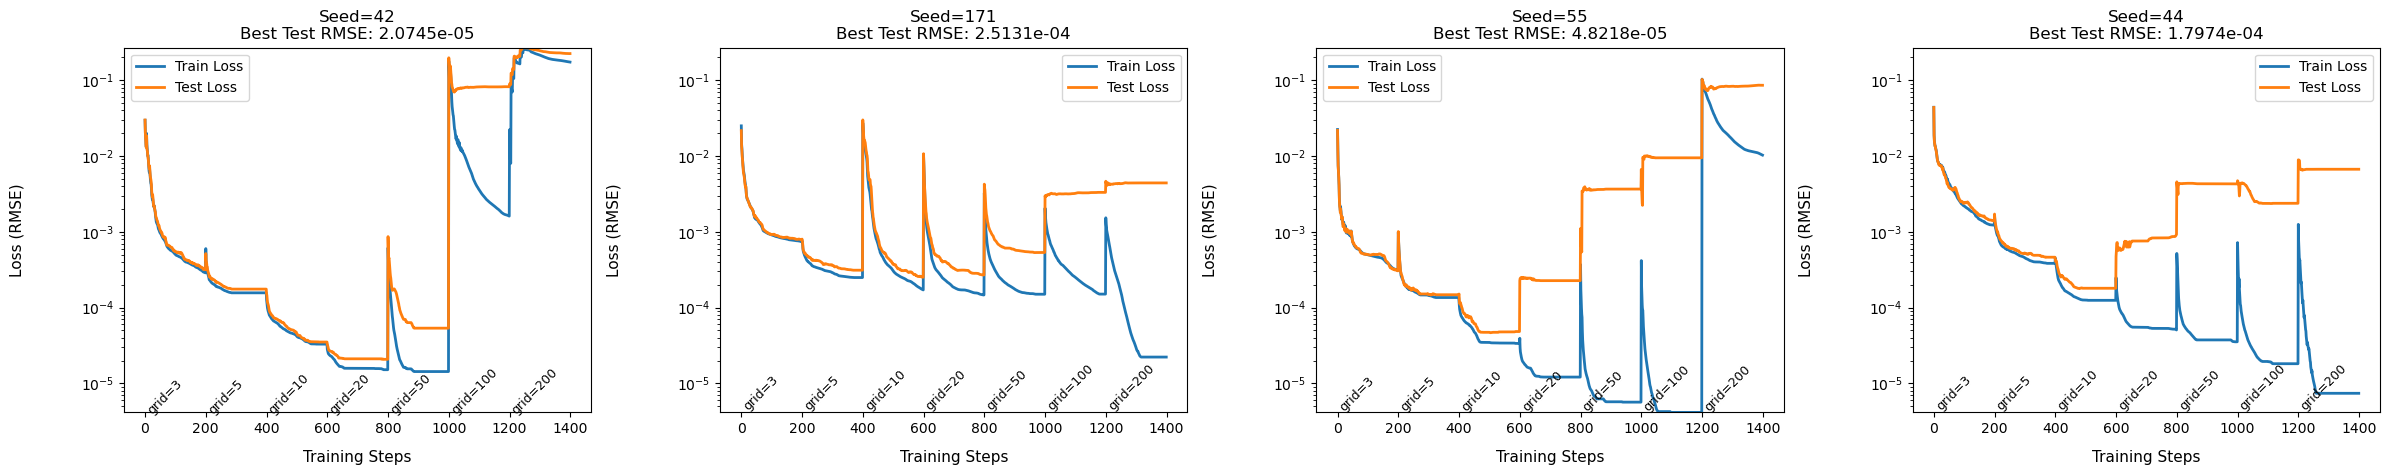

In [93]:
diff_seeds_results_dict = {
    # '500 samples': (best_test_rmse, results),
    'Seed=42': (best_test_rmse_1, results_1),
    'Seed=171': (best_test_rmse_2, results_2),
    'Seed=55': (best_test_rmse_3, results_3),
    'Seed=44': (best_test_rmse_4, results_4)
}

plot_train_test_loss_small_multiples(diff_seeds_results_dict, dataset_name='I.6.20', title='')

## Together plots

In [154]:
with open('diff_seeds_results_big_size.pkl', 'rb') as f:
    big_seeds = pickle.load(f)

with open('diff_seeds_results_big_size_seeds2.pkl', 'rb') as f:
    big_seeds2 = pickle.load(f)

with open('diff_seeds_results.pkl', 'rb') as f:
    small_seeds = pickle.load(f)

with open('diff_seeds_results_seeds2.pkl', 'rb') as f:
    small_seeds2 = pickle.load(f)

In [155]:
_big_seeds = {k: (v[0], [[None, v[1], None],None]) for k,v in big_seeds.items()}
_big_seeds2 = {k: (v[0], [[None, v[1], None],None]) for k,v in big_seeds2.items()}
_small_seeds = {k: (v[0], [[None, v[1], None],None]) for k,v in small_seeds.items()}
_small_seeds2 = {k: (v[0], [[None, v[1], None],None]) for k,v in small_seeds2.items()}

big = {**_big_seeds, **_big_seeds2}
small = {**_small_seeds, **_small_seeds2}

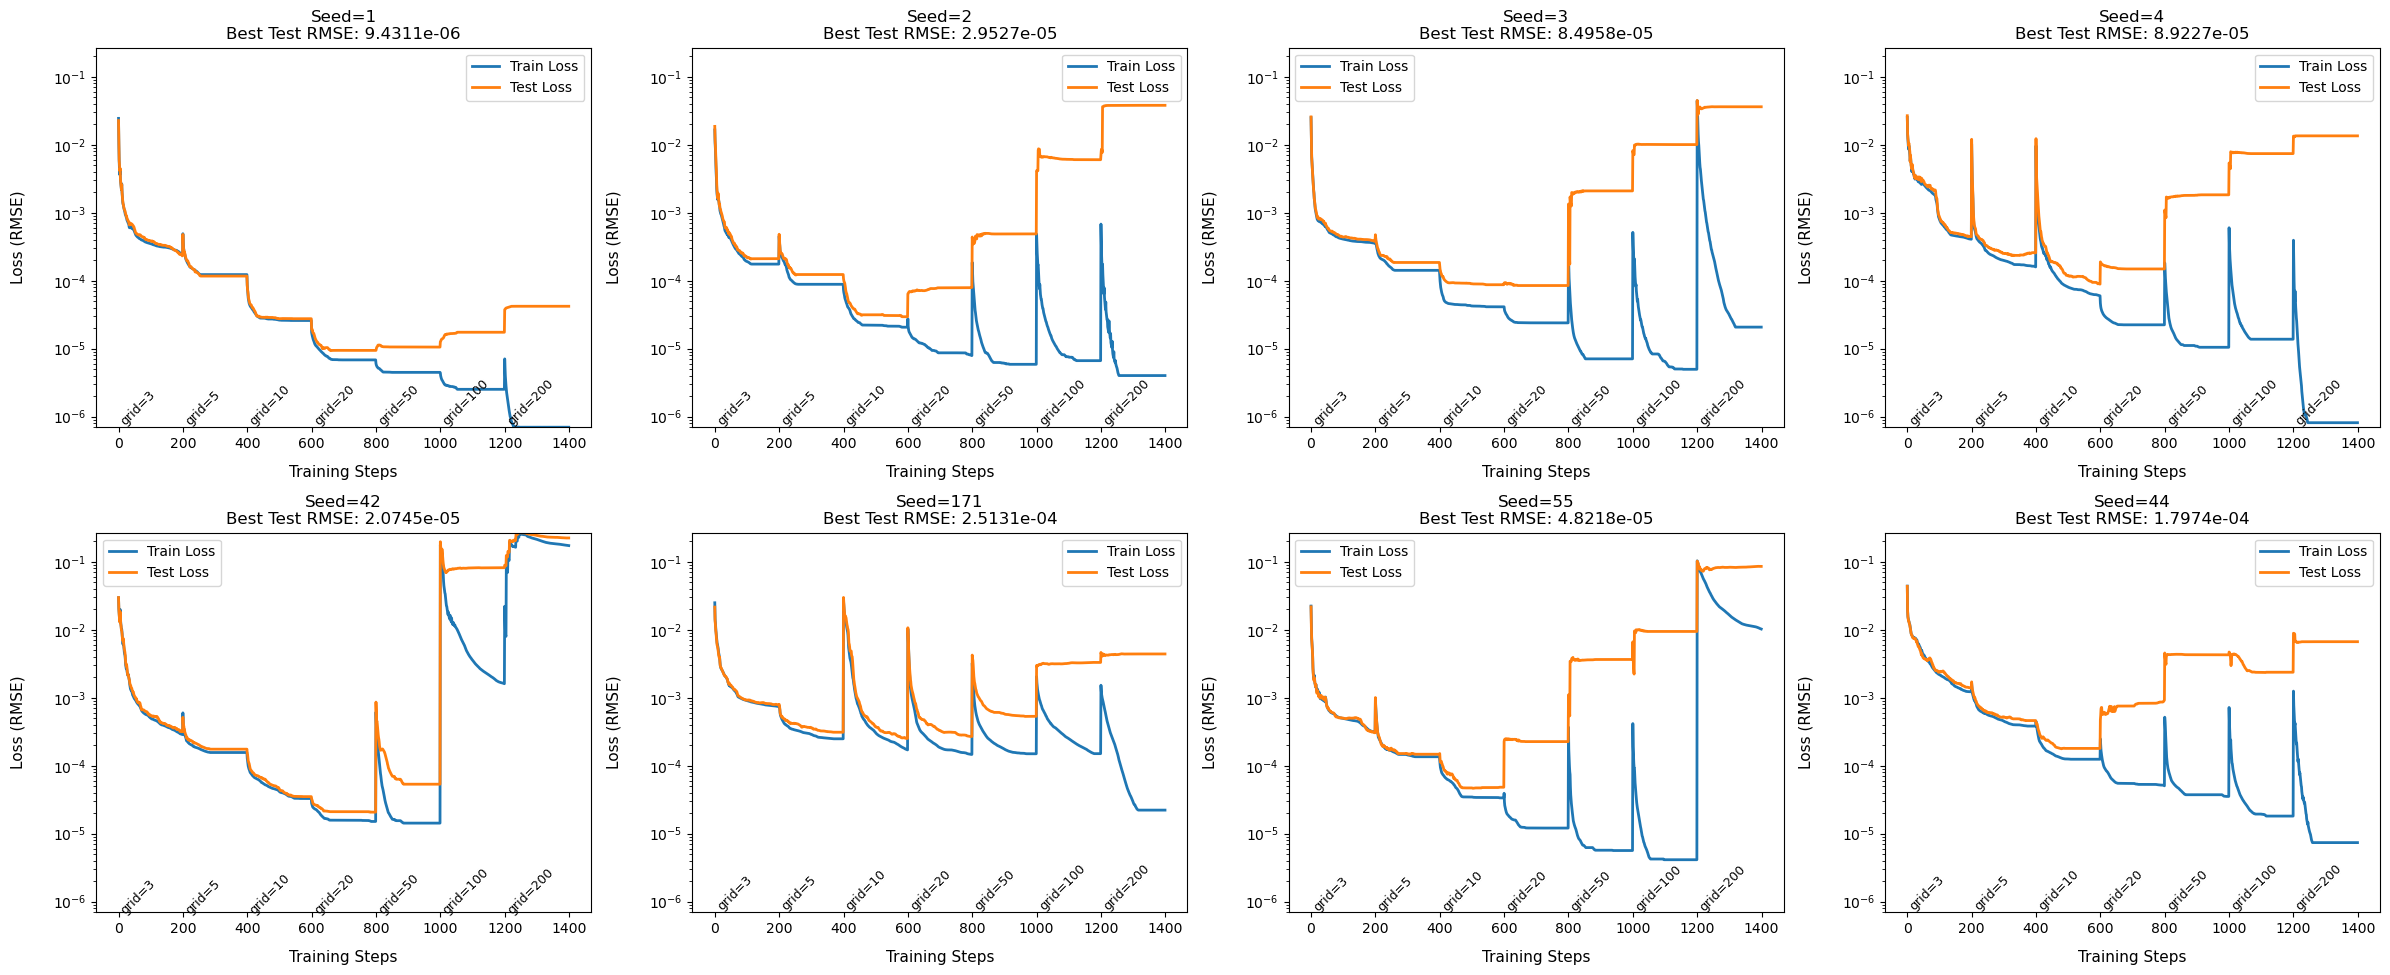

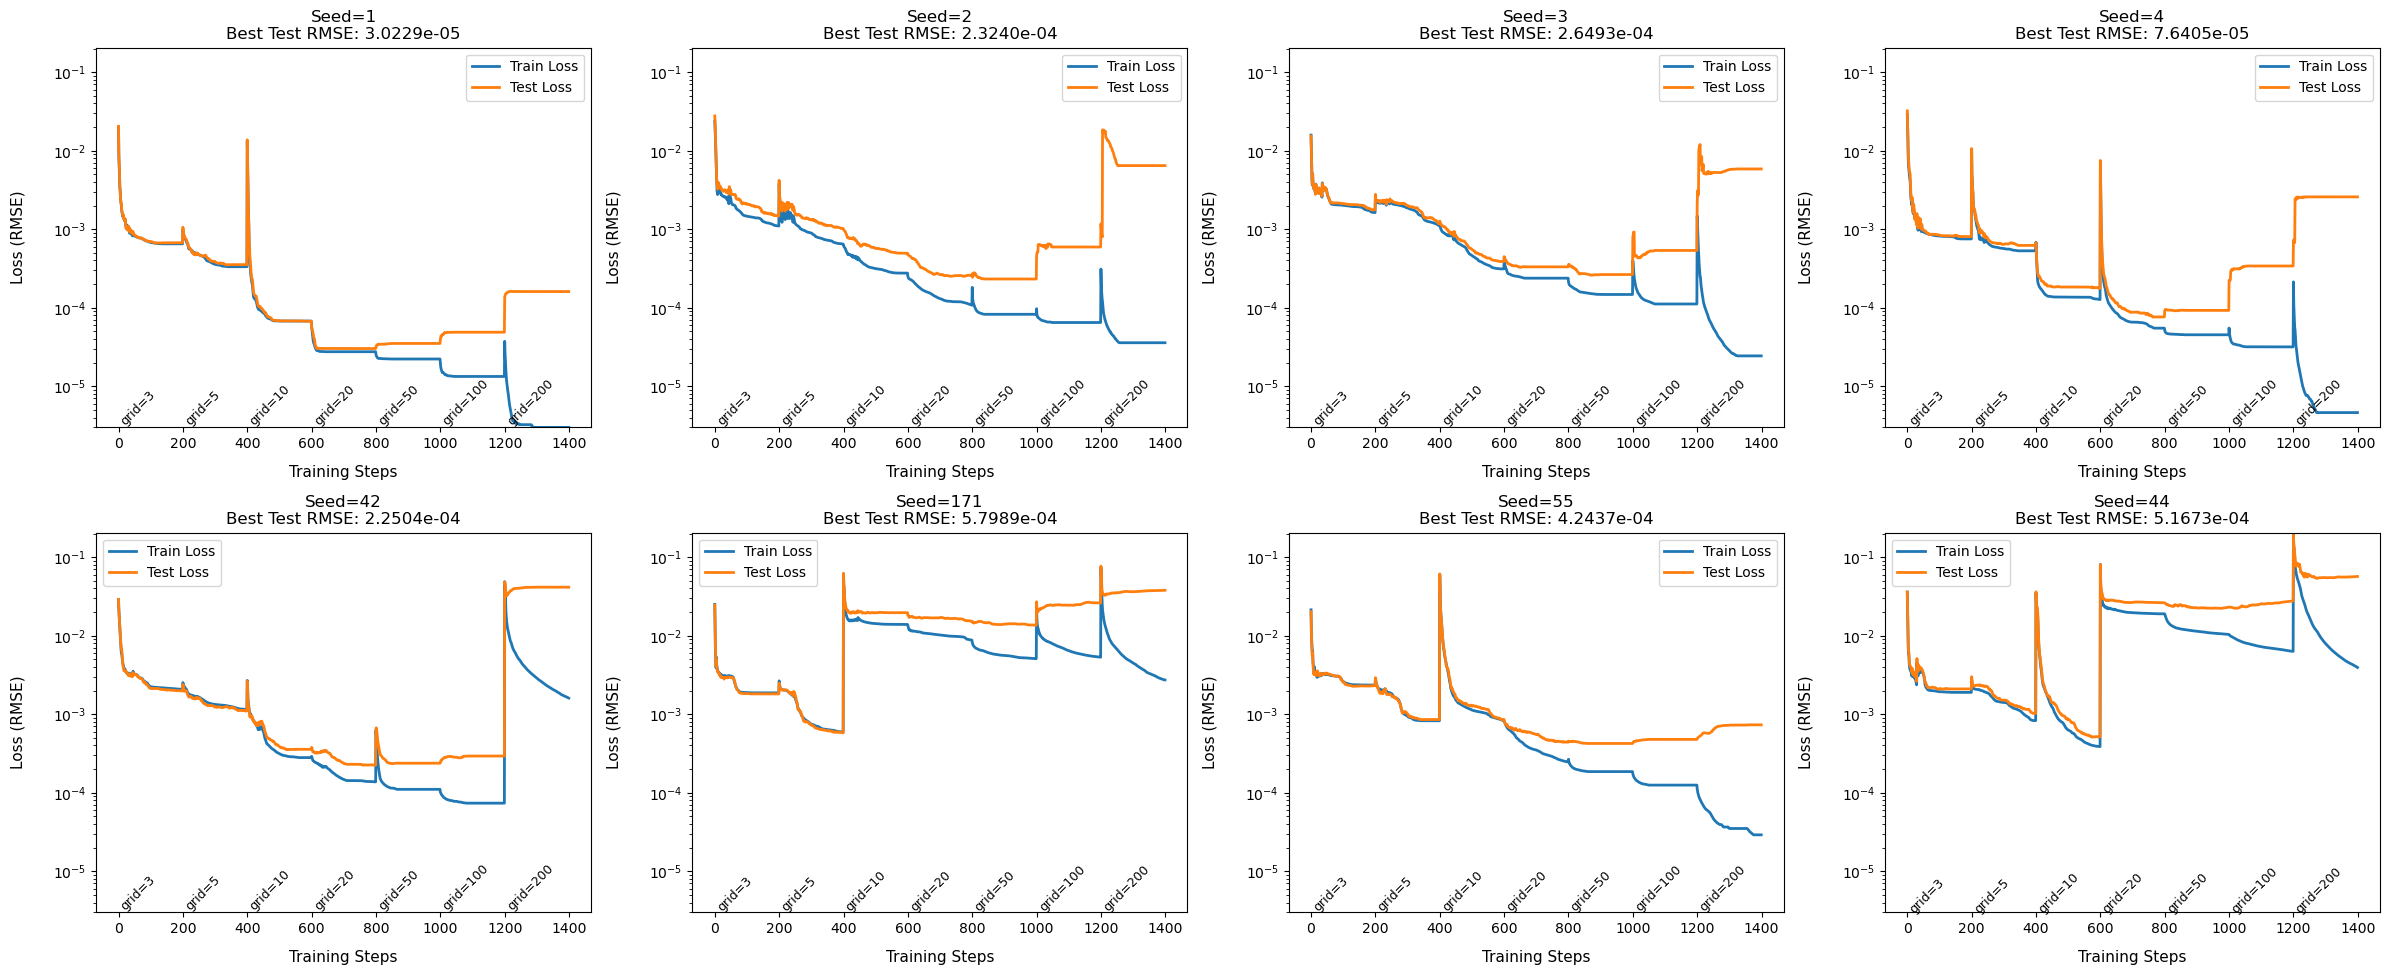

In [158]:
plot_train_test_loss_small_multiples(big, dataset_name='I.6.20', title='')

plot_train_test_loss_small_multiples(small, dataset_name='I.6.20', title='')